In [1]:
import os
import glob
import json 
import random
from pathlib import Path
from difflib import SequenceMatcher


import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches
from google.colab.patches import cv2_imshow
from os.path import exists
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


True


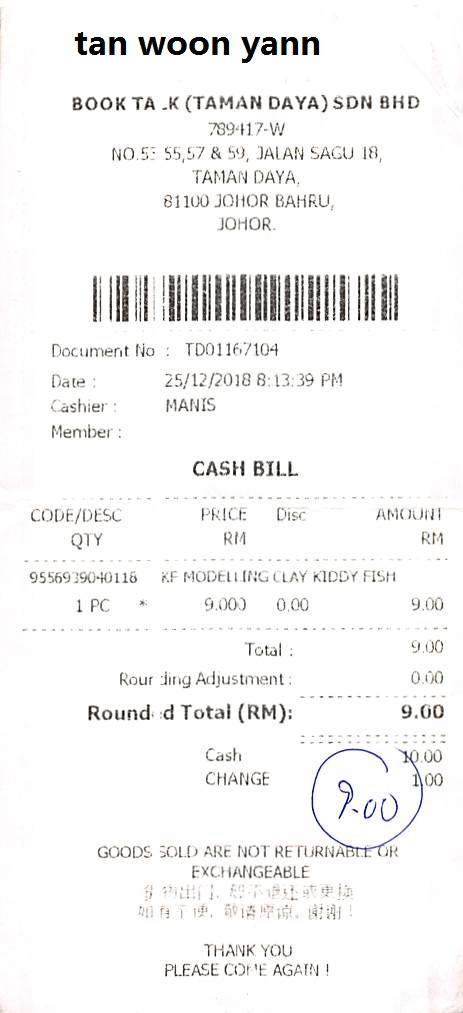

In [2]:
sroie_folder_path = Path('/content/drive/MyDrive/SROIE/')
_TRAIN_IMG_FOLDER_= 'train/img/'
_TEST_IMG_FOLDER_ = 'test/img/'
_TRAIN_BOX_FOLDER_ = 'train/box/'
_TEST_BOX_FOLDER_ = 'test/box/'
_TRAIN_ENT_FOLDER_ = 'train/entities/'
_TEST_ENT_FOLDER_ = 'test/entities/'

test_img = 'X00016469612.jpg'
test_box = 'X00016469612.txt'
test_ent = test_box
example_file = os.path.join(sroie_folder_path, _TRAIN_IMG_FOLDER_, test_img)
file_exists = exists(example_file)
print(file_exists)

img = cv2.imread(example_file)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r', errors='ignore', encoding = 'utf-8') as f:
    for line in f.read().splitlines():
      print(line)
      if len(line) == 0:
        continue
        
      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      # From the splited line we save (filename, [bounding box points], text line).
      # The filename will be useful in the future
      bbox_and_words_list.append([path.stem, *bbox, text])
    
  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'], dtype=np.int16)
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])
  return dataframe



# Example usage
bbox_file_path = os.path.join(sroie_folder_path, _TRAIN_BOX_FOLDER_, test_box)
print("== File content ==")
#!head -n 5 "{bbox_file_path}"

bbox = read_bbox_and_words(path=Path(bbox_file_path))
print("\n== Dataframe ==")
bbox.head(5)

== File content ==
72,25,326,25,326,64,72,64,TAN WOON YANN
50,82,440,82,440,121,50,121,BOOK TA .K(TAMAN DAYA) SDN BND
205,121,285,121,285,139,205,139,789417-W
110,144,383,144,383,163,110,163,NO.53 55,57 & 59, JALAN SAGU 18,
192,169,299,169,299,187,192,187,TAMAN DAYA,
162,193,334,193,334,211,162,211,81100 JOHOR BAHRU,
217,216,275,216,275,233,217,233,JOHOR.
50,342,279,342,279,359,50,359,DOCUMENT NO : TD01167104
50,372,96,372,96,390,50,390,DATE:
165,372,342,372,342,389,165,389,25/12/2018 8:13:39 PM
48,396,117,396,117,415,48,415,CASHIER:
164,397,215,397,215,413,164,413,MANIS
49,423,122,423,122,440,49,440,MEMBER:
191,460,298,460,298,476,191,476,CASH BILL
30,508,121,508,121,523,30,523,CODE/DESC
200,507,247,507,247,521,200,521,PRICE
276,506,306,506,306,522,276,522,DISC
374,507,441,507,441,521,374,521,AMOUNT
69,531,102,531,102,550,69,550,QTY
221,531,247,531,247,545,221,545,RM
420,529,443,529,443,547,420,547,RM
27,570,137,570,137,583,27,583,9556939040116
159,570,396,570,396,584,159,584,KF MODEL

<ipython-input-3-c44e0fafcd41>:30: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  bbox = read_bbox_and_words(path=Path(bbox_file_path))


,filename,x0,y0,x2,y2,line
0,X00016469612,72,25,326,64,TAN WOON YANN
1,X00016469612,50,82,440,121,BOOK TA .K(TAMAN DAYA) SDN BND
2,X00016469612,205,121,285,139,789417-W
3,X00016469612,110,144,383,163,"NO.53 55,57 & 59, JALAN SAGU 18,"
4,X00016469612,192,169,299,187,"TAMAN DAYA,"


In [4]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe

# Example usage
entities_file_path = os.path.join(sroie_folder_path, _TRAIN_ENT_FOLDER_, test_ent)
print("== File content ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==
{
    "company": "BOOK TA .K (TAMAN DAYA) SDN BHD",
    "date": "25/12/2018",
    "address": "NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.",
    "total": "9.00"
}

== Dataframe ==


,company,date,address,total
0,BOOK TA .K (TAMAN DAYA) SDN BHD,25/12/2018,"NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 8...",9.00


In [5]:
# Assign a label to the line by checking the similarity
# of the line and all the entities
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()
         
        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1
         
        if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5):
          return column.upper()  
        if (column.upper() != 'ADDRESS' and (matches_count > 0.8*len(line_set))) or matches_count == len(entity_set):           
            return column.upper()
    return "O"


line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: BOOK TA .K(TAMAN DAYA) SDN BND
Assigned label: COMPANY


In [6]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(15)

,filename,x0,y0,x2,y2,line,label
0,X00016469612,72,25,326,64,TAN WOON YANN,O
1,X00016469612,50,82,440,121,BOOK TA .K(TAMAN DAYA) SDN BND,COMPANY
2,X00016469612,205,121,285,139,789417-W,O
3,X00016469612,110,144,383,163,"NO.53 55,57 & 59, JALAN SAGU 18,",ADDRESS
4,X00016469612,192,169,299,187,"TAMAN DAYA,",COMPANY
5,X00016469612,162,193,334,211,"81100 JOHOR BAHRU,",ADDRESS
6,X00016469612,217,216,275,233,JOHOR.,ADDRESS
7,X00016469612,50,342,279,359,DOCUMENT NO : TD01167104,O
8,X00016469612,50,372,96,390,DATE:,O
9,X00016469612,165,372,342,389,25/12/2018 8:13:39 PM,DATE


In [7]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0
  

  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0', 'x2', 'line'] = [x0, x2, word]
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5 

  return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


,filename,x0,y0,x2,y2,line,label
1,X00016469612,50,82,440,121,BOOK TA .K(TAMAN DAYA) SDN BND,COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X00016469612,50,82,102,121,BOOK,COMPANY
1,X00016469612,107,82,133,121,TA,COMPANY
2,X00016469612,138,82,242,121,.K(TAMAN,COMPANY
3,X00016469612,247,82,312,121,DAYA),COMPANY
4,X00016469612,317,82,356,121,SDN,COMPANY
5,X00016469612,361,82,400,121,BND,COMPANY


In [8]:
from time import perf_counter
def dataset_creator(folder: Path):
  bbox_folder = folder / 'box'
  entities_folder = folder / 'entities'
  img_folder = folder / 'img'

  # Sort by filename so that when zipping them together
  # we don't get some other file (just in case)
  entities_files = sorted(entities_folder.glob("*.txt"))
  bbox_files = sorted(bbox_folder.glob("*.txt"))
  img_files = sorted(img_folder.glob("*.jpg"))

  data = []

  print("Reading dataset:")
  for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):            
    # Read the files
    bbox = read_bbox_and_words(bbox_file)
    entities = read_entities(entities_file)
    image = Image.open(img_file)

    # Assign labels to lines in bbox using entities
    bbox_labeled = assign_labels(bbox, entities)
    del bbox

    # Split lines into separate tokens
    new_bbox_l = []
    for index, row in bbox_labeled.iterrows():
      new_bbox_l += split_line(row)
    new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns, dtype=np.int16)
    del bbox_labeled


    # Do another label assignment to keep the labeling more precise 
    for index, row in new_bbox.iterrows():
      label = row['label']

      if label != "O":
        entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
        entity_set = entity_values.split()
        
        if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
            label = "S-" + label
        else:
            label = "O"
      
      new_bbox.at[index, 'label'] = label

    width, height = image.size
  
    data.append([new_bbox, width, height])

  return data

In [12]:
dataset_train = dataset_creator(sroie_folder_path / 'train')
dataset_test = dataset_creator(sroie_folder_path / 'test')

Output hidden; open in https://colab.research.google.com to view.

In [13]:
def normalize(points: list, width: int, height: int) -> list:
  x0, y0, x2, y2 = [int(p) for p in points]
  
  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


def write_dataset(dataset: list, output_dir: Path, name: str):
  print(f"Writing {name}ing dataset:")
  with open(output_dir / f"{name}.txt", "w+", encoding="utf8") as file, \
       open(output_dir / f"{name}_box.txt", "w+", encoding="utf8") as file_bbox, \
       open(output_dir / f"{name}_image.txt", "w+", encoding="utf8") as file_image:

      # Go through each dataset
      for datas in tqdm(dataset, total=len(dataset)):
        data, width, height = datas
        
        filename = data.iloc[0, data.columns.get_loc('filename')]

        # Go through every row in dataset
        for index, row in data.iterrows():
          bbox = [int(p) for p in row[['x0', 'y0', 'x2', 'y2']]]
          normalized_bbox = normalize(bbox, width, height)

          file.write("{}\t{}\n".format(row['line'], row['label']))
          file_bbox.write("{}\t{} {} {} {}\n".format(row['line'], *normalized_bbox))
          file_image.write("{}\t{} {} {} {}\t{} {}\t{}\n".format(row['line'], *bbox, width, height, filename))

        # Write a second newline to separate dataset from others
        file.write("\n")
        file_bbox.write("\n")
        file_image.write("\n")

In [14]:
dataset_directory = Path('/content/kaggle/working','dataset')

dataset_directory.mkdir(parents=True, exist_ok=True)

write_dataset(dataset_train, dataset_directory, 'train')
write_dataset(dataset_test, dataset_directory, 'test')

# Creating the 'labels.txt' file to the the model what categories to predict.
labels = ['COMPANY', 'DATE', 'ADDRESS', 'TOTAL']
IOB_tags = ['S']
with open(dataset_directory / 'labels.txt', 'w') as f:
  for tag in IOB_tags:
    for label in labels:
      f.write(f"{tag}-{label}\n")
  # Writes in the last label O - meant for all non labeled words
  f.write("O")

Writing training dataset:


100%|██████████| 626/626 [00:29<00:00, 21.49it/s]


Writing testing dataset:


100%|██████████| 347/347 [00:15<00:00, 22.01it/s]


In [15]:
%%bash
git clone https://github.com/microsoft/unilm.git
cd unilm/layoutlm/deprecated
pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/unilm/layoutlm/deprecated
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for layoutlm: filename=layoutlm-0.0-py3-none-any.whl size=11481 sha256=c0d6deea181910cbbc9f104d186c80b81d78871a21d23bb5a1524c89a9db2823
  Stored in directory: /tmp/pip-ephem-wheel-cache-6h8yyimt/wheels/31/2d/25/ecc19c4d92e12c3abaed9d94883bf8cee481e067d9635b66d1
Successfully built layoutlm
  Attempting uninstall: layoutlm
    Found existing installation: layoutlm 0.0
    Uninstalling layoutlm-0.0:
      Successfully uninstalled layoutlm-0.0


fatal: destination path 'unilm' already exists and is not an empty directory.


In [16]:
pretrained_model_folder_input= sroie_folder_path / Path('layoutlm-base-uncased') # Define it so we can copy it into our working directory

pretrained_model_folder=Path('/content/kaggle/working/layoutlm-base-uncased/') 
label_file=Path(dataset_directory, "labels.txt")

# Move to the script directory
os.chdir("/content/unilm/layoutlm/deprecated/examples/seq_labeling")

In [17]:
! cp -r "{pretrained_model_folder_input}" "{pretrained_model_folder}"
! sed -i 's/"num_attention_heads": 16,/"num_attention_heads": 12,/' "{pretrained_model_folder}/"config.json

In [18]:
! cat "/content/kaggle/working/layoutlm-base-uncased/config.json"

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "max_2d_position_embeddings": 1024,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

In [19]:
! rm -rf /kaggle/working/dataset/cached*

In [20]:
! python run_seq_labeling.py \
                            --data_dir /content/kaggle/working/dataset \
                            --labels /content/kaggle/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --max_seq_length 512 \
                            --do_lower_case \
                            --do_train \
                            --num_train_epochs 10 \
                            --logging_steps 50 \
                            --save_steps -1 \
                            --output_dir output \
                            --overwrite_output_dir \
                            --per_gpu_train_batch_size 8 \
                            --per_gpu_eval_batch_size 16

Epoch:   0% 0/10 [00:00<?, ?it/s]
Iteration:   0% 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:   1% 1/79 [00:03<04:45,  3.67s/it]
Iteration:   3% 2/79 [00:04<02:26,  1.90s/it]
Iteration:   4% 3/79 [00:04<01:41,  1.34s/it]
Iteration:   5% 4/79 [00:05<01:20,  1.07s/it]
Iteration:   6% 5/79 [00:06<01:08,  1.08it/s]
Iteration:   8% 6/79 [00:06<01:01,  1.19it/s]
Iteration:   9% 7/79 [00:07<00:56,  1.28it/s]
Iteration:  10% 8/79 [00:08<00:53,  1.34it/s]
Iteration:  11% 9/79 [00:09<00:50,  1.38it/s]
Iteration:  13% 10/79 [00:09<00:48,  1.42it/s]
Iteration:  14% 11/79 [00:10<00:47,  1.44it/s]
Iteration:  15% 12/79 [00:11<00:46,  1.45it/s]
Ite

In [25]:
# Evaluate for test set and make predictions
! python run_seq_labeling.py \
                            --data_dir /content/kaggle/working/dataset \
                            --labels /content/kaggle/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_predict \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir output \
                            --per_gpu_eval_batch_size 8

Evaluating: 100% 44/44 [00:10<00:00,  4.21it/s]


In [26]:
!cat output/test_results.txt

f1 = 0.95777887300805
loss = 0.07728807303713191
precision = 0.9504401695467883
recall = 0.9652317880794702


In [28]:
import cv2
from matplotlib import pyplot, patches
import matplotlib

data = pd.read_csv("/content/kaggle/working/dataset/test_image.txt", delimiter="\t", names=["name", "bbox", "size", "image"])
data_category = pd.read_csv("/content/kaggle/working/dataset/test.txt", delimiter="\t", names=["name", "true_category"]).drop(columns=["name"])
data_prediction_category = pd.read_csv("output/test_predictions.txt", delimiter=" ", names=["name", "prediction_category"]).drop(columns=["name"])

data_merge = data.merge(data_category, left_index=True, right_index=True)
merged = data_merge.merge(data_prediction_category, left_index=True, right_index=True)
merged_groups = list(merged.groupby("image"))

In [29]:
def display_prediction(data, file):
  colors = {
      "S-TOTAL": (255,0,0),
      "S-DATE": (0,255,0),
      "S-ADDRESS": (0,0, 255),
      "S-COMPANY": (255,255,0),
      "O": (192,192,192)
  }


  imagename = data[0].split(".")[0] + ".jpg"
  print("Filename:",imagename)
  image_path = str(sroie_folder_path / 'test' / 'img' / imagename)

  img=cv2.imread(image_path)
  img_prediction=cv2.imread(image_path)

  data = data[1]
  for bbox, category, prediction_category in zip(data['bbox'], data['true_category'], data['prediction_category']):
    (x1, y1, x2, y2) = [int(coordinate) for coordinate in bbox.split()]

    img_prediction = cv2.rectangle(img_prediction, (x1, y1), (x2, y2), colors[prediction_category], 2 if "O" in prediction_category else 4)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[category], 2 if "O" in category else 4)

  matplotlib.rcParams['figure.figsize'] = 15 ,18

  cv2.imwrite("prediction.jpg", img_prediction)

  # Plot
  fig, ax = matplotlib.pyplot.subplots(1,2)
  ax[0].set_title("Original", fontsize= 30)
  ax[0].imshow(img);
  ax[1].set_title("Prediction", fontsize= 30)
  ax[1].imshow(img_prediction);

  # Legend
  handles = [
      patches.Patch(color='yellow', label='Company'),
      patches.Patch(color='blue', label='Address'),
      patches.Patch(color='green', label='Date'),
      patches.Patch(color='red', label='Total'),
      patches.Patch(color='gray', label='Other')
  ]

  fig.legend(handles=handles, prop={'size': 25}, loc='lower center')

Filename: X00016469670.jpg


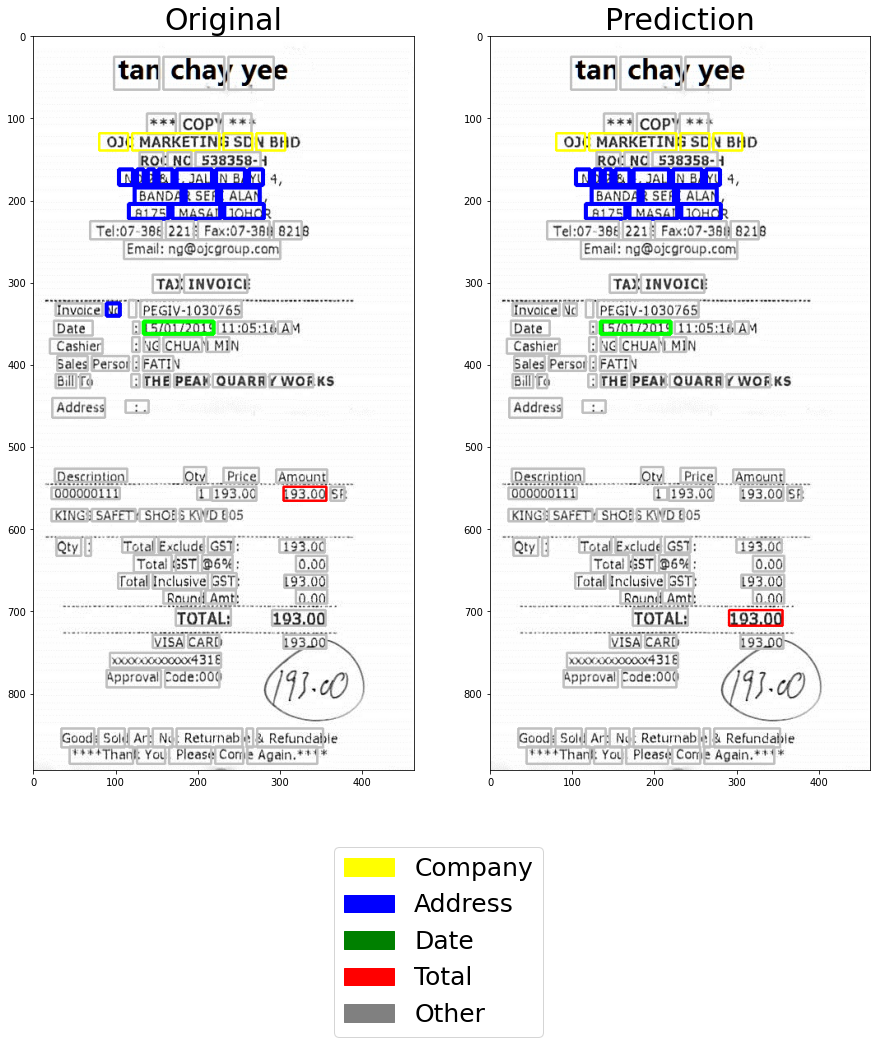

In [30]:
display_prediction(merged_groups[0], 'test')